In [3]:
import numpy as np
import os                                                                                                                                   
import matplotlib.pyplot as plt
plt.style.use(['science','nature','no-latex'])
%matplotlib inline
import pint 
import scipy.constants as C
ureg=pint.UnitRegistry()

In [2]:
def dataAccess():
    datafile=[]
    appendix='.asc'
    for filename in os.listdir():
        pre=os.path.splitext(filename)[0]
        tail=os.path.splitext(filename)[1]
        if tail==appendix:
            d=np.genfromtxt(filename)
            data=np.delete(d,0,axis=1)
            np.save(pre+'.npy',data)
            datafile.append(pre+'.npy')
    print('generated:',datafile)
    return datafile

dataAccess()

In [5]:
def outx(i):#position of pixel i at exit
    return (i-85)*15.5/910+2.45 #cm from pixel 86
def inx(i):#position of pixel i at entrance
    return (i-278)*8.8/214+2 #cm from pixel 279
ee,cc,me=C.elementary_charge,C.speed_of_light,C.electron_mass
def E1(i,j):
    y=23
    delta=outx(j)-inx(i)
    B0=-0.8
    r=(y*y+delta*delta)/(2*delta)# centimeter
    R=r/100#meter
    E=np.sqrt(R*R*ee*ee*B0*B0*cc*cc+me**2*cc*4)# IS
    return ((E*ureg.J).to('MeV')).magnitude #MeV
def divergence(i):#rad
    return np.arctan(((i-395)*8.8/214)/75)
def pfront(i):
    return(dis[i-354])


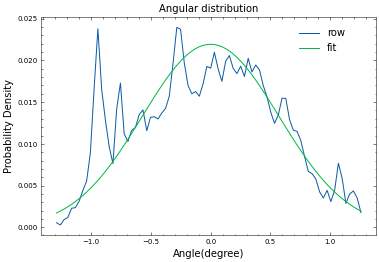

In [14]:
front=np.load('front.npy') #angular distrbition in front
front1=front[278:492,500:700]
y=np.sum(front1,axis=1)
y0=y-y.min()-20000
y0[y0<0]=0
y0[160:]=0
y1=y0[y0>0]/y0.sum()
#fig,ax=plt.subplots()
#ax.plot(y1)
center=0
t=y0[y0>0][41]
for i in range(214):
    if y0[i]==t:
        center=i+278
#fit row data to gauss
mu=41
sigma=np.sqrt(sum([y1[i]*(i-41)**2 for i in range(82)]))
from scipy.stats import norm
dis=norm.pdf(np.arange(0,82),mu,sigma)
fig,ax=plt.subplots()
ax.plot(divergence(np.arange(354,436))/np.pi*180,y1,label='row')
ax.plot(divergence(np.arange(354,436))/np.pi*180,dis,label='fit')
ax.set_title('Angular distribution',fontsize=10)
ax.set_xlabel('Angle(degree)',fontsize=10)
ax.set_ylabel('Probability Density',fontsize=10)
fig.legend(loc='center left',bbox_to_anchor=(0.7, 0.8),fontsize=10)
fig.savefig('tonight/front.jpg',dpi=600)

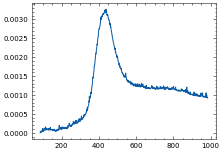

In [229]:
data=np.load('29.npy')
x=np.sum(data,axis=1)[85:985]
x0=x-x.min()
x1=x0/np.sum(x0)
fig,ax=plt.subplots()
plt.style.use(['science','nature','no-latex'])
ax.plot(np.arange(85,985),x1)
fig.savefig('29.jpg',dpi=600)

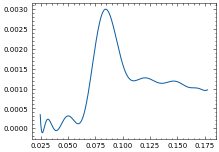

In [240]:
realx=outx(np.arange(85,985))/100
pback=np.poly1d(np.polyfit(realx,x1,deg=15))
fig,ax=plt.subplots()
ax.plot(realx,pback(realx))

In [410]:
dt=1e-4/cc
resolution=1000 #1 meter /1000
Bnew=np.load('Bnew.npy')
def getB(x,y):#meter
    i=int(y*resolution)
    j=int(x*resolution)
    if 0<=i<0.23*resolution and 0<=j<0.198*resolution:
        return np.abs(Bnew[i,j]/10) #from kgauss to T
    else:
        return 0

In [12]:
a=8.3**2+0.77**2
b=0.37**2+3.54**2
c=8.67**2+2.77**2
cosmirror=(a+c-b)/(2*np.sqrt(a)*np.sqrt(c))

In [506]:
class hit:
    num=0
    def __init__(self,x, energy, i):
      self.energy = energy
      self.inpixel = i
      self.x = x
      hit.num+=1

    def __lt__(self,other):
      return self.x<other.x
    def __gt__(self,other):
      return self.x>other.x

    @staticmethod
    def count():
      return hit.num
      
class Electron:
    def __init__(self,energy,pixel):
      self.x=inx(pixel)/100
      self.y,self.t=0,0
      self.gamma=energy*1e6*ee/(me*cc*cc)
      self.beta=np.sqrt(1-1/(self.gamma*self.gamma))
      self.ang=divergence(pixel)
      self.v=self.beta*cc
      self.vy= self.v*np.cos(self.ang)
      self.vx= self.v*np.sin(self.ang)
      self.m=self.gamma*me
      self.energy=energy
      self.pixel =pixel

    def show(self):
      print('x:',self.x)
      print('y:',self.y)
      print('vx:',self.vx)
      print('vy:',self.vy)
      print('ang:',self.ang)
      print('gamma',self.gamma)
    
    def onestep(self):
      B=getB(self.x,self.y)
      #r=self.m*self.v/np.abs(ee*B)
      omega=np.abs(ee*B/self.m)
      #sin,cos=self.vx/self.v,self.vy/self.v
      #self.x+=r*(1-np.cos(omega*dt))*sin
      self.x+=self.vx*dt
      self.y+=self.vy*dt
      self.ang+=omega*dt
      self.vx=self.v*np.sin(self.ang)
      self.vy=self.v*np.cos(self.ang)
       
    def run(self):
      #fig,ax=plt.subplots()
      #x0=[]
      #y0=[]
      i=0
      while(i<5000):
        #x0.append(self.x)
        #y0.append(self.y)
        x1,y1=self.x,self.y
        self.onestep()
        if self.y>=0.23 and 0.0245<=self.x<=0.19:
          finalx=x1+(self.x-x1)*(0.23-y1)/(self.y-y1)
          #ax.scatter(x0,y0)
          return hit(finalx,self.energy,self.pixel)
        elif self.x<0:
          #print('hit right')
          return 1
        elif self.x>0.198:
          #print('hit left')
          return 3
        elif self.y<0:
          #print('hit bottom')
          return 4
        elif self.y>0.23:
          #print('run away')
          return 2
        i+=1
      #ax.scatter(x0,y0)
      return 0

In [ ]:
class spectroMeter:
    def __init__(self,fstart=278,fend=492,flength=8.8,foffset=2,bstart=85,bend=995,blength=15.5,boffset=2.45):
      self.fstart = fstart #pixel
      self.fend = fend     #pixel
      self.flength=flength #cm 
      self.foffset=foffset #cm
      self.bstart = bstart
      self.bend = bend
      self.blength=blength
      self.boffset=boffset

    def inx(self,i):
      return ((i-self.fstart)*self.flength/(self.fend-self.fstart)+self.foffset)/100

    def outx(self,i):
      return ((i-self.bstart)*self.blength/(self.bend-self.bstart)+self.boffset)/100

    def divergence(self,i):#rad
      return np.arctan(((i-395)*self.flength/(self.fend-self.fstart))/75)

    def getHits(self,emin,emax):
      hits=[]
      for e in np.arange(emin,emax):
          for i in range(354,436):
              tmp=Electron(e,i).run()
              if isinstance(tmp,hit):
                  hits.append(tmp)
      hits.sort()
      name='hits.npy'
      np.save(name,np.array(hits))
      return name

    def count(self,name):
      hits=np.load(name)

      

In [509]:
hits=[]
for e in np.arange(71,500):
    for i in range(354,436):
        tmp=Electron(e,i).run()
        if isinstance(tmp,hit):
            hits.append(tmp)
hits.sort()
np.save('29'+'hits.npy',np.array(hits))

[<__main__.hit object at 0x00000203C1284430>, <__main__.hit object at 0x00000203BFAA6FA0>, <__main__.hit object at 0x00000203C12849A0>, <__main__.hit object at 0x00000203BFC45550>, <__main__.hit object at 0x00000203C7C722B0>, <__main__.hit object at 0x00000203C15399A0>, <__main__.hit object at 0x00000203C18E3D90>, <__main__.hit object at 0x00000203C1284310>, <__main__.hit object at 0x00000203C12845B0>, <__main__.hit object at 0x00000203C1284EE0>, <__main__.hit object at 0x00000203C12845E0>, <__main__.hit object at 0x00000203C1284670>, <__main__.hit object at 0x00000203C1284130>, <__main__.hit object at 0x00000203C1284910>, <__main__.hit object at 0x00000203C1284AC0>, <__main__.hit object at 0x00000203C12849D0>, <__main__.hit object at 0x00000203C12846D0>, <__main__.hit object at 0x00000203C7C0ECD0>, <__main__.hit object at 0x00000203C7C0EE50>, <__main__.hit object at 0x00000203C7C0EDF0>, <__main__.hit object at 0x00000203C7C0EF10>, <__main__.hit object at 0x00000203C7C0EC70>, <__main__

In [514]:
pE=np.zeros(500-71)

In [527]:
#distribute hits into pixel-bins
v=[[]]
vi=0
i=85
while(outx(i)/100<hits[0].x):
    i+=1
flag=i-1
for j in range(0,len(hits)):
    if outx(i-1)/100<hits[j].x<=outx(i)/100:
        v[vi].append(hits[j])
    else:
        i+=1
        vi+=1
        v.append([])

In [540]:
for k in range(985-286):
    total=0
    for j in range(len(v[k])):
        total+=pfront(v[k][j].inpixel)
    for j in range(len(v[k])):
        et=int(v[k][j].energy)-71
        pE[et]+=x1[286-85+k]*pfront(v[k][j].inpixel)/total

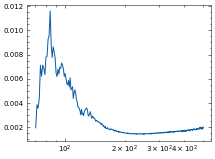

In [543]:
fig,ax=plt.subplots()
ax.plot(np.arange(71,500),pE)
ax.set_xscale('log')

In [537]:
max=2
t=0
for i in range(vi):
    if len(v[i])>max: 
        max=len(v[i])
        t=i
print(t+286,max)

517 121


In [532]:
print(i)
print(flag)

1057
286


In [535]:
len(v[1])

6

In [491]:
outx(350)

6.963736263736264

In [292]:
e1.x

0.06821214822710202

In [293]:
e1.y

9.999854508499239e-05

In [23]:
a=[1,2]
b=[0,3]
c=[-1,5]
print(np.amin([a,b],0))

[0 2]
